# RoBERTa Classification example
This notebook is an example of training the RoBERTa model for binary classification, with a max. sequence length of 256 for one epoch.  I use no evaluation during training as it slows the training down, if used, a val.tsv needs to be defined in the data/ directory, and the same preprocessing needs to be applied as for evaluation data (create_features and create_dataloader functions). 

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

import torch

## Define dictionary containing all model and environmental parameters

In [2]:
task_name  = 'roberta_256' 
params = {
    'data_dir': 'data/',                              # Directory of train.tsv, evaluation.tsv and test.tsv (optional)
    'params_dict_dir' : f'{task_name}_params.json',   # We save the dict here. It will be overwritten with more info. 
    'model_type':  'roberta',                         # Defines the model type
    'model': 'roberta-base',                          # Defines the exact model
    'task_name': 'binary',
    'output_dir': f'outputs/{task_name}/',            # The output will be saved in the output/bert_128 directory
    'cache_dir': 'cache/',                            
    'do_train': True,                                 # Need to specify True for training
    'do_eval': False,                                 # Need to specify True for evaluation
    'evaluate_during_training': False,                # If True, evaluation during training -> necessite val.tsv in data/
                                                      # Note: the training will be very long if evaluate_during_training is chosen  
    'fp16': False,                                    # If True, decrease precision of all calculation (needs apex package)
    'fp16_opt_level': 'O1',                           # Precision level (only relevant if fp16 is defined True)
    'max_seq_len': 256,                               # Max text taken for one sentence
    'output_mode': 'classification',
    'train_batch_size': 16,
    'eval_batch_size': 16,

    'gradient_accumulation_steps': 1,
    'num_train_epochs': 1,
    'weight_decay': 0,
    'learning_rate': 4e-5,
    'adam_epsilon': 1e-8,
    'warmup_ratio': 0.06,
    'warmup_steps': 0,
    'max_grad_norm': 1.0,

    'logging_steps': 50,
    'evaluate_during_training': False,
    'save_steps': 2000,
    'eval_all_checkpoints': True,

    'overwrite_output_dir': False,
    'reprocess_input_data': True,
    'notes': 'Using IMDB dataset',
    'device': torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

# Folder setup 

In [21]:
from modules.outils import *

create_reports_directory(params)
create_output_directory(params)

### Add tokenizer to the model

In [3]:
from pytorch_transformers import (WEIGHTS_NAME, BertConfig, BertForSequenceClassification, BertTokenizer,
                                  XLMConfig, XLMForSequenceClassification, XLMTokenizer, 
                                  XLNetConfig, XLNetForSequenceClassification, XLNetTokenizer,
                                  RobertaConfig, RobertaForSequenceClassification, RobertaTokenizer)
MODEL_CLASSES = {
    'bert': (BertConfig, BertForSequenceClassification, BertTokenizer),
    'xlnet': (XLNetConfig, XLNetForSequenceClassification, XLNetTokenizer),
    'xlm': (XLMConfig, XLMForSequenceClassification, XLMTokenizer),
    'roberta': (RobertaConfig, RobertaForSequenceClassification, RobertaTokenizer)
}

config_class, model_class, tokenizer_class = MODEL_CLASSES[params['model_type']]

config = config_class.from_pretrained(params['model'], num_labels=2, finetuning_task=params['task_name'])
tokenizer = tokenizer_class.from_pretrained(params['model'])
params["tokenizer"] = tokenizer

## Process data
### Create features from the data 

In [5]:
from modules.process import create_features

features, params = create_features(params, 'train')
eval_features, params = create_features(params, 'evaluation')
# Create val_features if evaluate during training is choosen
# val_features, params = create_features(params, 'val')

Loading features from cached file data/train_features_256_roberta-base..
Loading is finished from file data/train_features_256_roberta-base..
Adding train_example_length to the parameters dict and saving it in roberta_256_params.json
Loading features from cached file data/evaluation_features_256_roberta-base..
Loading is finished from file data/evaluation_features_256_roberta-base..
Adding evaluation_example_length to the parameters dict and saving it in roberta_256_params.json


### Create dataloaders

In [7]:
from modules.process import create_dataloader

# Create dataloader for train data
dataloader = create_dataloader(features, params, evaluation=False)
dataloader_name = f'{params["data_dir"]}dataloader_{params["max_seq_len"]}_{params["model"]}'
torch.save(dataloader, dataloader_name)

# Create dataloader for eval data
eval_dataloader, all_label_ids = create_dataloader(eval_features, params, evaluation=True)
eval_dataloader_name = f'{params["data_dir"]}eval_dataloader_{params["max_seq_len"]}_{params["model"]}'
torch.save(eval_dataloader, eval_dataloader_name)
torch.save(all_label_ids, f'{params["data_dir"]}eval_label_ids')
           
# Create dataloader for eval data during training if evaluate_during_training is defined in params
# val_dataloader, all_label_ids = create_dataloader(val_features, params, evaluation=True)
# val_dataloader_name = f'{params["data_dir"]}val_dataloader_{params["max_seq_len"]}_{params["model"]}'
# torch.save(val_dataloader, val_dataloader_name)
# torch.save(all_label_ids, f'{params["data_dir"]}val_label_ids')

# Define model 

In [8]:
model = model_class.from_pretrained(params['model'])
model.to(params["device"])

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=0)
      (position_embeddings): Embedding(514, 768)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

# Train

In [36]:
from modules.model_functions import train

params['num_train_epochs'] = 6
if params['do_train'] and params['evaluate_during_training']: 
    model, train_loss_set, global_step, tr_loss = train(dataloader, model, params, val_dataloader)
elif params['do_train']: 
    model, train_loss_set, global_step, tr_loss = train(dataloader, model, params, eval_dataloader)

INFO:modules.model_functions:***** Running training *****
INFO:modules.model_functions:  Num examples = 25000
INFO:modules.model_functions:  Num Epochs = 6
INFO:modules.model_functions:  Total train batch size  = 16
INFO:modules.model_functions:  Gradient Accumulation steps = 1
INFO:modules.model_functions:  Total optimization steps = 150000
Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

0.144207

Epoch:  17%|█▋        | 1/6 [07:33<37:45, 453.11s/it]

0.111141


0.715195

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



0.295068

INFO:modules.model_functions:Saving model checkpoint to outputs/roberta_256/checkpoint-4000


0.019660

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



0.099368

Epoch:  67%|██████▋   | 4/6 [30:11<15:05, 452.82s/it]

0.010080


0.003728

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



0.281516

Epoch: 100%|██████████| 6/6 [45:15<00:00, 452.60s/it]

0.091083


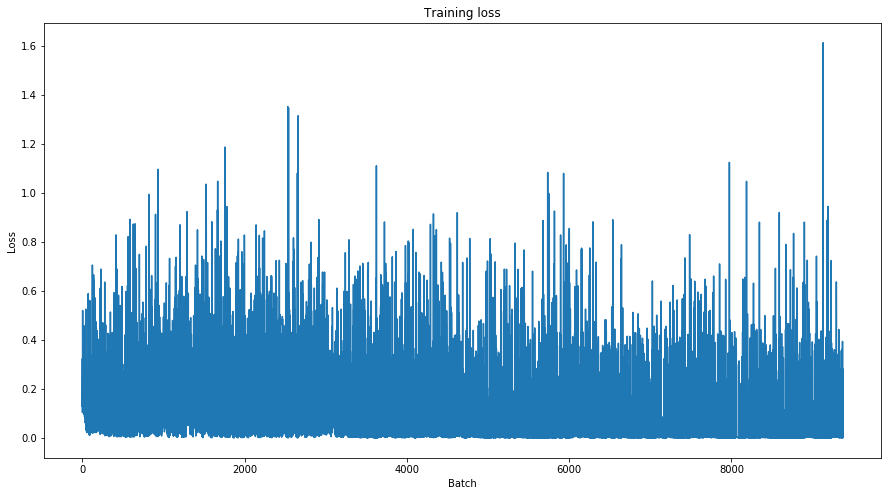

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [38]:
import os 

if "weights_name" not in params:
    params["weights_name"] = "pytorch_model.bin"
if "config_name" not in params:
    params["config_name"] = "config.json"

output_model_file = os.path.join(params["output_dir"], params["weights_name"])
output_config_file = os.path.join(params["output_dir"], params["config_name"])
print(f'Save model, config and vocab to {params["output_dir"]}..')
torch.save(model.state_dict(), output_model_file)
model.config.to_json_file(output_config_file)
tokenizer.save_vocabulary(params["output_dir"])
print(f'Model, config and vocab are saved in {params["output_dir"]}..')

Save model, config and vocab to outputs/roberta_256/..
Model, config and vocab are saved in outputs/roberta_256/..


# Evaluation

In [39]:
from modules.model_functions import evaluate 

results = evaluate(model, eval_dataloader, params, prefix="")
results

INFO:modules.model_functions:***** Eval results  *****
INFO:modules.model_functions:  accuracy = 0.92592
INFO:modules.model_functions:  eval_loss = 0.40667047336464
INFO:modules.model_functions:  f1-score = 0.9259436980166347
INFO:modules.model_functions:  fn = 922
INFO:modules.model_functions:  fp = 930
INFO:modules.model_functions:  logloss = 2.5540362078118326
INFO:modules.model_functions:  mcc = 0.8518401744568856
INFO:modules.model_functions:  model = roberta-base
INFO:modules.model_functions:  precision = 0.9256475855452511
INFO:modules.model_functions:  recall = 0.92624
INFO:modules.model_functions:  task_name = binary
INFO:modules.model_functions:  tn = 11570
INFO:modules.model_functions:  tp = 11578


{'mcc': 0.8518401744568856,
 'accuracy': 0.92592,
 'precision': 0.9256475855452511,
 'recall': 0.92624,
 'f1-score': 0.9259436980166347,
 'logloss': 2.5540362078118326,
 'tp': 11578,
 'tn': 11570,
 'fp': 930,
 'fn': 922,
 'task_name': 'binary',
 'model': 'roberta-base',
 'eval_loss': 0.40667047336464}